In [1]:
using CSV, DataFrames
using Microgrids
using NLopt # optimization solvers
using Printf # pretty print results
using PyCall
using PyPlot
using BenchmarkTools # for timing performance, optional

In [2]:
using Printf # pretty print results
using Random, Statistics

In [3]:

np=pyimport("numpy");
td = collect((0:nsteps-1)/24) ;


In [4]:
with_plots = isdefined(Main, :PyPlot)

true

#### default Hydrogen prices scenario
#electrolyzer and fuel cell investment price : 1600\$/kW

In [5]:
mg_base = new_microgrid()

Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableCompound{Float64}(ProductionUnit{Float64}[ProductionUnit{Float64}(2000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")], ProductionUnit{Float64}[ProductionUnit{Float64}(1.8e6, 0.0, 0.0625, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "Kg", "KWh")]), ProductionUnit{Float64}[ProductionUnit{Float64}(2.0e6, 0.0, 56.0, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "KWh", "Kg")], TankCompound{Float64}(Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0), Tank{Float64}(1.0e7, 500.0, 0.0025, 25.0, 0.0, 0.0, 0.1, 1.0, 14.0, 1.0, 1.0)), Battery{Float64}(5.0e6, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 1.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(3.0e6, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e

In [6]:
mg_base.tanks.h2Tank.investment_price

500.0

####  Hydrogen  High prices scenario
#electrolyzer and fuel cell investment price : 2200\$/kW

In [7]:
capex_hi= [400., 0.0, 2200., 500., 2200., 350., 1200., 3500.]

8-element Vector{Float64}:
  400.0
    0.0
 2200.0
  500.0
 2200.0
  350.0
 1200.0
 3500.0

In [8]:
mg_high= new_microgrid(capex_hi)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableCompound{Float64}(ProductionUnit{Float64}[ProductionUnit{Float64}(2000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")], ProductionUnit{Float64}[ProductionUnit{Float64}(2.2e6, 0.0, 0.0625, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "Kg", "KWh")]), ProductionUnit{Float64}[ProductionUnit{Float64}(500000.0, 0.0, 56.0, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "KWh", "Kg")], TankCompound{Float64}(Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0), Tank{Float64}(350000.0, 500.0, 0.0025, 25.0, 0.0, 0.0, 0.1, 1.0, 14.0, 1.0, 1.0)), Battery{Float64}(400000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 1.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000

#### function to compare 2 operations trajectories

In [9]:
function comp_oper_traj(mg1,mg2, oper_traj1, oper_traj2, costs1,costs2)
 
  ns=Int64(nsteps/730)
     z=zeros(Float64,ns)
tm=zeros(Float64,ns +1)
    tm[end]=nsteps/24
 for i=1:ns
    z[i]= oper_traj1.LoH[i*730+1]
    tm[i]=(i-1)*730/24 
end
    fig,( ax1, ax2) = plt.subplots(2,1,sharex=true)
    y1 = min.(oper_traj1.Prenew_pot,mg1.load)
    y2 = max.( oper_traj1.Pbatt,0.0)
    y3 = oper_traj1.Pfc
    y4 = abs.(min.( oper_traj1.Pbatt,0.0))
    y5 = oper_traj1.Pelyz
    y6 = oper_traj1.power_shedding
    y7 = oper_traj1.power_curtailment
    
    Y1=np.vstack([y1,y2,y3,y4,y5,y6,y7])
    
 
    y1 = min.(oper_traj2.Prenew_pot,mg2.load)
    y2 = max.( oper_traj2.Pbatt,0.0)
    y3 = oper_traj2.Pfc
    y4 = abs.(min.( oper_traj2.Pbatt,0.0))
    y5 = oper_traj2.Pelyz
    y6 = oper_traj2.power_shedding
    y7 = oper_traj2.power_curtailment
    
    Y2=np.vstack([y1,y2,y3,y4,y5,y6,y7])
 
        
        fieldNames =(["Pren used by the load","battery_discharge","fuel cell","battery_charge", "elyz","shedding","spillage"])
    
    fieldColors = (["orange","green","pink","green","magenta","black","red"])
         
    
    ax1.plot(td, oper_traj1.Prenew_pot,lw=2, "tab:orange", label="ren")
    ax1.plot(td, mg1.load,lw=2, label="load")
    stacks1 = ax1.stackplot(td,Y1,labels=fieldNames, colors = fieldColors,alpha=0.8)
     ax2.plot(td, oper_traj2.Prenew_pot,lw=2, "tab:orange", label="ren")
    ax2.plot(td, mg2.load,lw=2, label="load")
    stacks2 = ax2.stackplot(td,Y2,labels=fieldNames, colors = fieldColors,alpha=0.8)
    
    
    stacks1[2].set_hatch("-")
    stacks1[4].set_hatch("+")
    stacks1[6].set_hatch("\\")   
    stacks1[7].set_hatch("\\") 
    
    stacks2[2].set_hatch("-")
    stacks2[4].set_hatch("+")
    stacks2[6].set_hatch("\\")   
    stacks2[7].set_hatch("\\") 
    
    ax3=ax1.twinx()
    ax3.set_ylim(0, 2)
    ax3.plot(td, oper_traj1.Ebatt[1:end-1]/mg1.storage.energy_rated, ls="--","C2",label="hourly battery level")

    
    
    ax4=ax2.twinx()
    ax4.set_ylim(0, 2)
    ax4.plot(td, oper_traj2.Ebatt[1:end-1]/mg2.storage.energy_rated, ls="--","C2",label="hourly battery level")

    
           
    
    ax1.set_title("hourly power repartition")
    ax2.set_title("hourly power repartition")
    ax1.legend()
    ax1.grid(true)
    ax1.set(ylabel="kW")
    ax2.legend()
    ax3.legend()
     ax4.legend()
    ax2.grid(true)
    ax2.set(ylabel="kw")
     fig.tight_layout()
   
     return fig,(ax1, ax2,ax3,ax4)
    
end


comp_oper_traj (generic function with 1 method)

#### optimization setup

In [10]:
"""Simulate the performance of a Microgrid project of size `x`
with x=[power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind]

Returns mg, traj, stats, costs
"""
    function simulate_microgrid(x,capex,dispatch)
     mg=new_microgrid(x)
    # Split decision variables (converted MW → kW):
    oper_traj = operation(mg, dispatch)
    ini=[0.0,oper_traj.LoH[end]/mg.tanks.h2Tank.capacity, oper_traj.Ebatt[end]/mg.storage.energy_rated]
    mg=new_microgrid(x,capex,ini)
    # Launch simulation:
    traj, stats, costs = simulate(mg,dispatch)

    return  traj ,stats, costs
end

simulate_microgrid

In [11]:
"Multi-objective criterion for microgrid performance: lcoe, shedding rate"
function obj_multi(x,capex,dispatch)
    traj,stats, costs = simulate_microgrid(x,capex,dispatch)
    # Extract KPIs of interest
    lcoe = costs.lcoe # $/kWh
    shed_rate = stats.shed_rate; # in [0,1]
    return lcoe, shed_rate, costs,traj
end

obj_multi

In [12]:
function obj(x, grad,capex,dispatch, shed_max, w_shed_max=1e5)
    lcoe, shed_rate,costs,traj = obj_multi(x,capex,dispatch)
    over_shed = shed_rate - shed_max
    if over_shed > 0.0
        penalty = w_shed_max*over_shed
    else
        penalty = 0.0
    end
    J = lcoe + penalty
end

obj (generic function with 2 methods)

In [13]:
Pload_max = maximum(Pload)

xmin = [0., 1e-3, 0., 0., 0., 0.] # 1e-3 instead of 0.0, because LCOE is NaN if ther is exactly zero generation
x0 = X * (1e-3)
xmax = [20.0, 10.0, 1.1, 5., 2. , 15. ] * (Pload_max/1000)

6-element Vector{Float64}:
 34.14
 17.07
  1.8777000000000001
  8.535
  3.414
 25.605

In [14]:
x0

6-element Vector{Float64}:
  5.0
  3.0
  1.8
  2.0
  1.8
 10.0

In [15]:
"""Optimize sizing of microgrid based on the `obj` function

Parameters:
- `x0`: initial sizing (for the algorithms which need them)
- `shed_max`: load shedding penalty threshold (same as in `obj`)
- `algo` could be one of LN_SBPLX, GN_DIRECT, GN_ESCH...
- `maxeval`: maximum allowed number of calls to the objective function,
  that is to the microgrid simulation
- `xtol_rel`: termination condition based on relative change of sizing, see NLopt doc.
- `srand`: random number generation seed (for algorithms which use some stochastic search)

Problem bounds are taken as the global variables `xmin`, `xmax`,
but could be added to the parameters as well.
"""
function optim_mg(x0,capex, shed_max,dispatch, algo=:LN_SBPLX, maxeval=1000, xtol_rel=1e-8, srand=1)
    nx = length(x0) # number of optim variables
    opt = Opt(algo, nx)
    NLopt.srand(srand)
    
    opt.lower_bounds = xmin
    opt.upper_bounds = xmax
    opt.min_objective = (x, grad) -> obj(x, grad,capex,dispatch, shed_max)
    opt.xtol_rel = xtol_rel
    opt.maxeval = maxeval
    
    (fopt, xopt, ret) = optimize(opt, x0)
    return xopt, ret, opt.numevals
end

optim_mg

In [16]:
capexlist=[capex_def,capex_hi]
dispatchlist=[dispatch_1,dispatch_2]

2-element Vector{Function}:
 dispatch_1 (generic function with 2 methods)
 dispatch_2 (generic function with 1 method)

In [18]:
algo = :GN_CRS2_LM # could be one of GN_CRS2_LM, GN_DIRECT, GN_ESCH, LN_SBPLX...
shed_max = 0.00# in [0,1]
maxeval=100000
xtol_rel=1e-8
xopt_base, ret, numevals = optim_mg(x0,capex_def, shed_max,dispatch_1, algo, maxeval,xtol_rel,6)

@printf("%s algo: %s after %d iterations. \nx*=", algo, ret, numevals)
println(round.(xopt_base*1000; digits=5)) # kW
lcoe_opt, shed_rate_opt,costs,traj_opt = obj_multi(xopt_base,capex_def,dispatch_1)
println("LCOE*: ", lcoe_opt)
println("shed*: ", shed_rate_opt)

GN_CRS2_LM algo: XTOL_REACHED after 44902 iterations. 
x*=[11380.11584, 16425.59372, 1499.74022, 354.72914, 1405.23487, 6377.35589]
LCOE*: 0.472324294850319
shed*: 0.0


In [19]:
traj_opt.LoH[1]/(xopt_base[end]*1000)

0.13910787752736056

In [20]:
traj_opt.Ebatt[end]/(xopt_base[1]*1000)

0.0

In [21]:
traj_opt.LoH[end]/(xopt_base[end]*1000)

0.13910787752736056

In [22]:
traj_opt.Ebatt[1]/(xopt_base[1]*1000)

0.0

In [23]:
ini_opt=[0.0,traj_opt.LoH[1]/(xopt_base[end]*1000),traj_opt.Ebatt[end]/(xopt_base[1]*1000)]

3-element Vector{Float64}:
 0.0
 0.13910787752736056
 0.0

In [24]:
 mg=new_microgrid(xopt_base,capex_def,ini_opt)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableCompound{Float64}(ProductionUnit{Float64}[ProductionUnit{Float64}(2000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")], ProductionUnit{Float64}[ProductionUnit{Float64}(1405.2348706758517, 0.0, 0.0625, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "Kg", "KWh")]), ProductionUnit{Float64}[ProductionUnit{Float64}(354.7291392005546, 0.0, 56.0, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "KWh", "Kg")], TankCompound{Float64}(Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0), Tank{Float64}(6377.355888656224, 500.0, 0.0025, 25.0, 0.0, 0.13910787752736056, 0.1, 1.0, 14.0, 1.0, 1.0)), Battery{Float64}(11380.115841362738, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 1.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(16425

In [26]:
  traj, stats, costs = simulate(mg,dispatch_1)

(OperationTraj{Float64}([1405.234703485372, 1165.2888071173184, 845.1166282068943, 479.78521739130485, 95.05103381608512, -235.4169256696523, -404.6630978467483, -388.0389352980492, -333.3648992931039, -278.442595827634  …  -354.7291392005545, -354.7291392005545, 1374.5398909533117, 1325.4614992280208, 1412.4708809444858, 1531.3027020820045, 1504.7141803771758, 1415.12269446997, 1476.7141803771758, 1427.8882665978665], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [47.76529651462817, 165.71119288268167, 368.8833717931057, 666.2147826086951, 982.9489661839149, 1270.4169256696523, 1436.6630978467483, 1460.0389352980492, 1475.364899293104, 1486.442595827634  …  7429.88134976139, 5066.7296056781, 35.46010904668831, 44.53850077197928, 54.52911905551428, 55.69729791799552, 56.28581962282429, 56.877305530030014, 56.28581962282429, 55.111733402133495], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [28]:
if with_plots
    fig1, ax1, ax2= plot_oper_traj(mg,traj)
     
    pygui(true)
   plt.show()
   
end;

In [27]:
loh_ini=zeros(Float64,100)
loh_end=zeros(Float64,100)
for i in 1:100
    mg=new_microgrid(xopt_base,capex_def,[0.0,i/(100.0),0.0])
    traj, stats, costs = simulate(mg,dispatch_2)
    loh_ini[i]=traj.LoH[1]/(xopt_base[end]*1000)
    loh_end[i]=traj.LoH[end]/(xopt_base[end]*1000)
end
fig,ax = plt.subplots()
ax.plot(loh_ini,loh_end)
ax.plot(loh_ini,loh_ini,label="x=x")
ax.set(title="niveau d'hydrogène final en fonction du niveau initial",xlabel="initial level",ylabel="final level")
ax.legend()



LoadError: ArgumentError: ref of NULL PyObject

In [28]:
loh_end

100-element Vector{Float64}:
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 ⋮
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002
 0.10000000000000002

#### Pareto front of simple dispatch strategies

## Dispatch 1

In [16]:
pareto_shed_1=collect(0.0:0.0000025:0.00004)

17-element Vector{Float64}:
 0.0
 2.5e-6
 5.0e-6
 7.5e-6
 1.0e-5
 1.25e-5
 1.5e-5
 1.75e-5
 2.0e-5
 2.25e-5
 2.5e-5
 2.75e-5
 3.0e-5
 3.25e-5
 3.5e-5
 3.75e-5
 4.0e-5

In [17]:
pareto_shed_2=collect(0.00005:0.00005:0.001)

20-element Vector{Float64}:
 5.0e-5
 0.0001
 0.00015
 0.0002
 0.00025
 0.0003
 0.00035
 0.0004
 0.00045
 0.0005
 0.00055
 0.0006
 0.00065
 0.0007
 0.00075
 0.0008
 0.00085
 0.0009
 0.00095
 0.001

In [18]:
pareto_shed_new=[pareto_shed_1;pareto_shed_2]

37-element Vector{Float64}:
 0.0
 2.5e-6
 5.0e-6
 7.5e-6
 1.0e-5
 1.25e-5
 1.5e-5
 1.75e-5
 2.0e-5
 2.25e-5
 2.5e-5
 2.75e-5
 3.0e-5
 ⋮
 0.00045
 0.0005
 0.00055
 0.0006
 0.00065
 0.0007
 0.00075
 0.0008
 0.00085
 0.0009
 0.00095
 0.001

In [19]:
 algo = :GN_CRS2_LM # could be one of GN_CRS2_LM, GN_DIRECT, GN_ESCH, LN_SBPLX...
pareto_lcoe1 = zeros(Float64,37)
maxeval=100000
for i in eachindex(pareto_shed_new)
    xopt, ret, numevals = optim_mg(x0,capex_def, pareto_shed_new[i],dispatch_1, algo, maxeval)
    lcoe_opt, shed_rate_opt = obj_multi(xopt,capex_def,dispatch_1)
    mg = new_microgrid(xopt) ;
     pareto_lcoe1[i]=lcoe_opt
     @printf("%s algo: %s after %d iterations. \nx*=", algo, ret, numevals)
println(round.(xopt*1000; digits=6)) # kW
end

GN_CRS2_LM algo: XTOL_REACHED after 27579 iterations. 
x*=[23347.453054, 16995.434773, 1171.625098, 145.151887, 1069.897236, 3671.421094]
GN_CRS2_LM algo: XTOL_REACHED after 23474 iterations. 
x*=[14479.12082, 12330.740779, 1454.01445, 357.983297, 1398.000414, 6604.40332]
GN_CRS2_LM algo: XTOL_REACHED after 43408 iterations. 
x*=[11292.04383, 12381.74684, 1513.152367, 403.535709, 1404.807522, 7483.875178]
GN_CRS2_LM algo: XTOL_REACHED after 36424 iterations. 
x*=[14368.285183, 12086.645801, 1466.594398, 377.82366, 1397.999828, 6644.018807]
GN_CRS2_LM algo: XTOL_REACHED after 27129 iterations. 
x*=[23288.523592, 13932.486344, 1503.644564, 153.792031, 1148.491, 3589.505247]
GN_CRS2_LM algo: XTOL_REACHED after 35784 iterations. 
x*=[9411.805542, 7854.990826, 1838.971553, 691.517119, 1467.810727, 8330.188014]
GN_CRS2_LM algo: XTOL_REACHED after 20457 iterations. 
x*=[14087.670875, 11110.284058, 1784.509317, 329.459563, 1385.015408, 5878.375851]
GN_CRS2_LM algo: XTOL_REACHED after 22029 ite

In [60]:
pareto_lcoe1

37-element Vector{Float64}:
 0.5191261655500403
 0.4274416512728466
 0.4168988491304812
 0.42413328106116827
 0.4891206964493164
 0.36157491950261683
 0.4184650491601368
 0.42143634282172665
 0.39983759213324405
 0.3945343534500265
 0.359868392102726
 0.3575728953788394
 0.3535145026153155
 ⋮
 0.33358420913900316
 0.33317240505760065
 0.33288403545080547
 0.33259178476622053
 0.3323038865016544
 0.3320324002658368
 0.33182090244724916
 0.3315309115556263
 0.3313519234645792
 0.3310820186183037
 0.33086752538870745
 0.3306481155866563

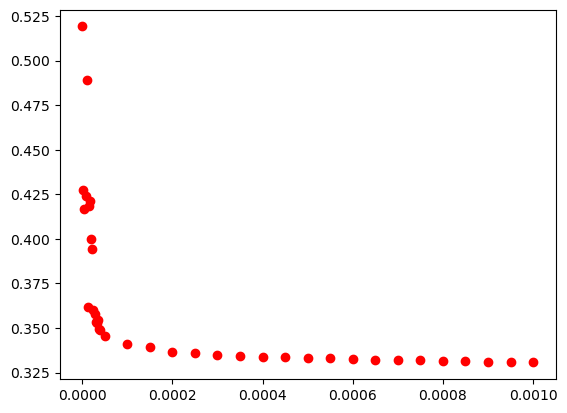

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000023ED370B9D0>

In [20]:

plot(pareto_shed_new, pareto_lcoe1,"or")

#### Dispatch 2

In [21]:
pareto_shed=collect(0.0:0.00005:0.001)

21-element Vector{Float64}:
 0.0
 5.0e-5
 0.0001
 0.00015
 0.0002
 0.00025
 0.0003
 0.00035
 0.0004
 0.00045
 0.0005
 0.00055
 0.0006
 0.00065
 0.0007
 0.00075
 0.0008
 0.00085
 0.0009
 0.00095
 0.001

In [22]:
 algo = :GN_CRS2_LM # could be one of GN_CRS2_LM, GN_DIRECT, GN_ESCH, LN_SBPLX...
pareto_lcoe2 = zeros(Float64,21)
maxeval=100000
xtol_rel=1e-8
srand=6
for i in eachindex(pareto_shed)
    xopt, ret, numevals = optim_mg(x0,capex_def, pareto_shed[i],dispatch_2, algo, maxeval,xtol_rel,srand)
    lcoe_opt, shed_rate_opt,costs = obj_multi(xopt,capex_def,dispatch_2)
     pareto_lcoe2[i]=lcoe_opt
    @printf("%s algo: %s after %d iterations. \nx*=", algo, ret, numevals)
println(round.(xopt*1000; digits=6)) # kW
     
end

GN_CRS2_LM algo: XTOL_REACHED after 15658 iterations. 
x*=[385.10361, 5736.596414, 1877.7, 1824.243216, 1451.582529, 18784.003256]
GN_CRS2_LM algo: XTOL_REACHED after 16156 iterations. 
x*=[283.262884, 5851.085497, 1877.7, 1787.004647, 1433.122784, 18681.967208]
GN_CRS2_LM algo: XTOL_REACHED after 30896 iterations. 
x*=[234.617202, 5718.847261, 1877.7, 1831.120711, 1418.332267, 18770.023747]
GN_CRS2_LM algo: XTOL_REACHED after 19427 iterations. 
x*=[213.034068, 5729.508642, 1877.7, 1827.352604, 1398.602756, 18744.084675]
GN_CRS2_LM algo: XTOL_REACHED after 17800 iterations. 
x*=[207.048184, 5733.970119, 1877.699999, 1825.041847, 1382.46422, 18725.700322]
GN_CRS2_LM algo: XTOL_REACHED after 24532 iterations. 
x*=[207.047483, 5743.432015, 1877.7, 1822.431568, 1365.557753, 18697.878631]
GN_CRS2_LM algo: XTOL_REACHED after 19744 iterations. 
x*=[207.047212, 5745.756866, 1877.7, 1820.428026, 1354.513028, 18677.917241]
GN_CRS2_LM algo: XTOL_REACHED after 18188 iterations. 
x*=[207.047855, 57

In [65]:
pareto_lcoe2

21-element Vector{Float64}:
 0.39078145064078484
 0.3897167595872884
 0.3889187421559924
 0.3882208773709961
 0.3877457126222478
 0.3872830140871662
 0.3869314617040828
 0.3866093997742454
 0.3862748492377523
 0.3859420172864854
 0.3855989821868398
 0.3853056534794736
 0.3850450309623384
 0.38475375716614985
 0.38445168894265797
 0.3841779167937007
 0.38391067889055736
 0.3836582968516015
 0.38340062329469277
 0.38318131724331905
 0.3829285732063151

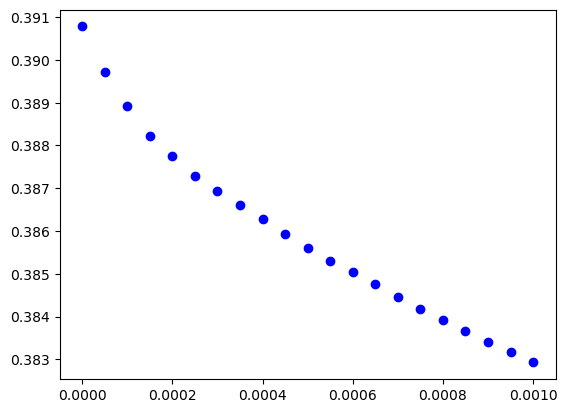

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000023ED89144F0>

In [23]:
plot(pareto_shed, pareto_lcoe2,"ob")

In [24]:
if with_plots
    fig,(ax1,ax2,ax3,ax4) = comp_oper_traj(mg_base,mg_hi, traj1,traj2,costs1,costs2)
     
    
end;

LoadError: UndefVarError: `mg_hi` not defined

In [52]:
df2 = DataFrame(  fc_elyz_capex=Float64[],shed_max=Float64[],dispatch=Int64[],algo=String[],
     srand=Int[], ret=String[],numevals=Int64[],
     lcoe_opt=Float64[], shed_rate_opt=Float64[], capex=Float64[],opex=Float64[],
    xopt_sto=Float64[], xopt_pv=Float64[], xopt_wind=Float64[] ,xopt_elyz=Float64[],  
    xopt_fc=Float64[],  xopt_hyTank=Float64[]
)

Row,fc_elyz_capex,shed_max,dispatch,algo,srand,ret,numevals,lcoe_opt,shed_rate_opt,capex,opex,xopt_sto,xopt_pv,xopt_wind,xopt_elyz,xopt_fc,xopt_hyTank
,Float64,Float64,Int64,String,Int64,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [53]:
"""uniformly random vector between xmin and xmax, for a given PRNG seed"""
function x0_rng(seed, xmin, xmax)
    n = length(xmin)
    rng = MersenneTwister(seed)
    xmin + rand(rng, n).*(xmax-xmin)
end
# Test with 3 different seeds:
[x0_rng(0, xmin, xmax) x0_rng(0, xmin, xmax) x0_rng(1, xmin, xmax) x0_rng(2, xmin, xmax)]
     

6×4 Matrix{Float64}:
 28.1193    28.1193    8.05818    12.5224
 15.5399    15.5399    5.9157      8.94308
  0.309005   0.309005  0.58717     0.394798
  1.5135     1.5135    0.0675057   6.99305
  0.952097   0.952097  1.66812     1.71168
  5.21002    5.21002   5.40184    14.3223

In [49]:
nrand = 10
srand_list = collect(1:nrand)
algo_list = [:GN_CRS2_LM, :GN_ISRES, :LN_SBPLX]
shed_max_list = [0.,0.00001,0.0001, 0.001, 0.01]

5-element Vector{Float64}:
 0.0
 1.0e-5
 0.0001
 0.001
 0.01

In [50]:
 x0 = x0_rng(1, xmin, xmax)

6-element Vector{Float64}:
 8.058178420902282
 5.915698915242573
 0.587169874444634
 0.06750573373843591
 1.668124201891417
 5.4018408162693134

In [51]:
capexlist

2-element Vector{Vector{Float64}}:
 [400.0, 0.0, 1600.0, 500.0, 1600.0, 350.0, 1200.0, 3500.0]
 [400.0, 0.0, 2200.0, 500.0, 2200.0, 350.0, 1200.0, 3500.0]

In [54]:
xtol_rel=1e-8
maxeval=100000
i=0
for capex in capexlist, shed in shed_max_list, dispatch in dispatchlist,algo in algo_list, srand in srand_list
    x0 = x0_rng(srand, xmin, xmax)
    xopt, ret, numevals = optim_mg(x0,capex, shed,dispatch, algo, maxeval,xtol_rel,srand)
    lcoe_opt, shed_rate_opt,costs = obj_multi(xopt,capex,dispatch)
       xopt = round.(xopt*1000; digits=2)
 push!(df2,(capex[3],shed,findfirst(==(dispatch),dispatchlist),String(algo),srand,
        String(ret),numevals,lcoe_opt,shed_rate_opt, costs.system.investment,costs.system.om,  
         xopt[1], xopt[2], xopt[3], xopt[4], xopt[5], xopt[6]
        ))
    i= i+1
    @printf(" %d,  %s algo: %s after %d iterations.",i, algo, ret, numevals)
      
end

 1,  GN_CRS2_LM algo: XTOL_REACHED after 21888 iterations. 2,  GN_CRS2_LM algo: XTOL_REACHED after 23035 iterations. 3,  GN_CRS2_LM algo: XTOL_REACHED after 20841 iterations. 4,  GN_CRS2_LM algo: XTOL_REACHED after 33104 iterations. 5,  GN_CRS2_LM algo: XTOL_REACHED after 19458 iterations. 6,  GN_CRS2_LM algo: XTOL_REACHED after 34149 iterations. 7,  GN_CRS2_LM algo: XTOL_REACHED after 13242 iterations. 8,  GN_CRS2_LM algo: XTOL_REACHED after 13759 iterations. 9,  GN_CRS2_LM algo: XTOL_REACHED after 15504 iterations. 10,  GN_CRS2_LM algo: XTOL_REACHED after 17949 iterations. 11,  GN_ISRES algo: MAXEVAL_REACHED after 100000 iterations. 12,  GN_ISRES algo: XTOL_REACHED after 66964 iterations. 13,  GN_ISRES algo: XTOL_REACHED after 72958 iterations. 14,  GN_ISRES algo: MAXEVAL_REACHED after 100000 iterations. 15,  GN_ISRES algo: MAXEVAL_REACHED after 100000 iterations. 16,  GN_ISRES algo: XTOL_REACHED after 67785 iterations. 17,  GN_ISRES algo: MAXEVAL_REACHED after 100000 iterations. 18,

In [55]:
df2

Row,fc_elyz_capex,shed_max,dispatch,algo,srand,ret,numevals,lcoe_opt,shed_rate_opt,capex,opex,xopt_sto,xopt_pv,xopt_wind,xopt_elyz,xopt_fc,xopt_hyTank
,Float64,Float64,Int64,String,Int64,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1600.0,0.0,1,GN_CRS2_LM,1,XTOL_REACHED,21888,0.516505,0.0,3.54974e7,1.04221e7,30304.5,12227.8,1811.59,76.75,990.08,2732.21
2,1600.0,0.0,1,GN_CRS2_LM,2,XTOL_REACHED,23035,0.494657,0.0,3.66674e7,9.1398e6,16979.5,16846.3,1251.93,254.45,1398.0,5348.99
3,1600.0,0.0,1,GN_CRS2_LM,3,XTOL_REACHED,20841,0.519126,0.0,3.72518e7,9.90446e6,23347.5,16995.4,1171.63,145.15,1069.9,3671.42
4,1600.0,0.0,1,GN_CRS2_LM,4,XTOL_REACHED,33104,0.428714,0.0,3.19499e7,7.85836e6,14406.9,12391.2,1482.9,335.07,1398.0,6528.59
5,1600.0,0.0,1,GN_CRS2_LM,5,XTOL_REACHED,19458,0.533625,0.0,3.77074e7,1.06257e7,24400.9,15913.2,1811.59,61.05,983.0,2513.25
6,1600.0,0.0,1,GN_CRS2_LM,6,XTOL_REACHED,34149,0.519126,0.0,3.72522e7,9.90425e6,23347.5,16996.3,1171.27,145.41,1069.87,3671.71
7,1600.0,0.0,1,GN_CRS2_LM,7,XTOL_REACHED,13242,0.519543,0.0,3.72996e7,9.90014e6,23353.2,17070.0,1152.01,157.62,1067.98,3687.44
8,1600.0,0.0,1,GN_CRS2_LM,8,XTOL_REACHED,13759,0.519543,0.0,3.72996e7,9.90014e6,23353.2,17070.0,1152.01,157.62,1067.98,3687.43
9,1600.0,0.0,1,GN_CRS2_LM,9,XTOL_REACHED,15504,0.535548,0.0,3.78175e7,1.06989e7,24386.3,15853.3,1877.7,53.61,983.0,2448.82


In [56]:
CSV.write("df4_dataset.csv", df2)

"df4_dataset.csv"

In [ ]:
df_gsrand = groupby(df2, [ :dispatch, :shed_max, :algo])

In [ ]:
df_stats = combine(df_gsrand,
    :lcoe_opt => minimum, :lcoe_opt => mean,:lcoe_opt=> maximum
   )

In [15]:
x_1=[16553.83,12465.94,1520.34,1090.55,1594.19, 16478.6]

6-element Vector{Float64}:
 16553.83
 12465.94
  1520.34
  1090.55
  1594.19
 16478.6

In [16]:
x_2=[385.18,5129.99,1877.68,2062.95,1449.69,19090.86]

6-element Vector{Float64}:
   385.18
  5129.99
  1877.68
  2062.95
  1449.69
 19090.86

In [16]:
x=[385.10371, 6300.94927, 1877.7, 1659.50772, 1402.49858, 18108.3348]


6-element Vector{Float64}:
   385.10371
  6300.94927
  1877.7
  1659.50772
  1402.49858
 18108.3348

In [17]:
mg_best_1=new_microgrid(x/1000)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableCompound{Float64}(ProductionUnit{Float64}[ProductionUnit{Float64}(2000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")], ProductionUnit{Float64}[ProductionUnit{Float64}(1402.49858, 0.0, 0.0625, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "Kg", "KWh")]), ProductionUnit{Float64}[ProductionUnit{Float64}(1659.50772, 0.0, 56.0, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "KWh", "Kg")], TankCompound{Float64}(Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0), Tank{Float64}(18108.3348, 500.0, 0.0025, 25.0, 0.0, 0.1, 0.1, 1.0, 14.0, 1.0, 1.0)), Battery{Float64}(385.10371, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 1.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(6300.94927, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [18]:
mg_best_2=new_microgrid(x_2/1000)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableCompound{Float64}(ProductionUnit{Float64}[ProductionUnit{Float64}(2000.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")], ProductionUnit{Float64}[ProductionUnit{Float64}(1449.69, 0.0, 0.0625, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "Kg", "KWh")]), ProductionUnit{Float64}[ProductionUnit{Float64}(2062.95, 0.0, 56.0, 0.0, 1600.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "KWh", "Kg")], TankCompound{Float64}(Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0), Tank{Float64}(19090.86, 0.8, 0.0025, 25.0, 0.0, 0.12, 0.1, 1.0, 6.5, 1.0, 1.0)), Battery{Float64}(385.18, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 1.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(5129.99, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.00000000

In [18]:
 traj_opt_1, stats_opt_1, costs_opt_1 = simulate_microgrid(x/1000,capex_def,dispatch_2)

(OperationTraj{Float64}([0.0, 0.0, 0.0, 0.0, -152.66865379016417, -555.5833786426488, -766.726384993473, -755.9933270190545, -705.1816919563057, -652.052662571276  …  -1385.7737041340329, -459.668511888558, 1365.6033464960426, 1314.2370472195723, 1398.728624934677, 1517.266045332343, 1490.5292062500257, 1400.7886559364292, 1462.5292062500257, 1413.9991819642896], [1393.1970446260718, 1123.5267967322582, 752.1518082951447, 311.8878763246554, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [59.80295537392815, 207.47320326774187, 461.84819170485525, 834.1121236753446, 1230.6686537901642, 1590.5833786426488, 1798.726384993473, 1827.9933270190545, 1847.1816919563057, 1860.052662571276  …  2864.773704134033, 1967.668511888558, 44.39665350395732, 55.76295278042775, 68.27137506532279, 69.73395466765682, 70.47079374997435, 71.2113440635707, 70.47079374997435, 69.00081803571048], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [20]:
 traj_opt_2, stats_opt_2, costs_opt_2 = simulate_microgrid(x_2/1000,capex_def,dispatch_2)

(OperationTraj{Float64}([1393.19768160701, 1123.5290065975537, 752.1567275920686, 311.89676072710176, -152.65554553374636, -555.5664368161733, -766.7072261674093, -755.9738564611696, -705.1620170168376, -651.9508880879123  …  -857.3078513294276, -100.44125782780884, 1365.6038193793947, 1314.2376411691146, 1398.7293521155375, 1517.2667880916197, 1490.5299568576174, 1400.789414431866, 1462.5299568576174, 1413.9999169146868], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [59.802318392990045, 207.47099340244637, 461.84327240793135, 834.1032392728982, 1230.6555455337464, 1590.5664368161733, 1798.7072261674093, 1827.9738564611696, 1847.1620170168376, 1859.9508880879123  …  2336.3078513294276, 1608.4412578278088, 44.3961806206053, 55.76235883088544, 68.27064788446253, 69.7332119083804, 70.47004314238262, 71.21058556813414, 70.47004314238262, 69.00008308531335], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 

In [17]:
function plot_oper_traj(mg, oper_traj)
 ns=Int64(nsteps/730)
     z=zeros(Float64,ns)
tm=zeros(Float64,ns +1)
    tm[end]=nsteps/24
 for i=1:ns
    z[i]= oper_traj.LoH[i*730+1]
    tm[i]=(i-1)*730/24 
end
    fig,( ax1, ax2) = plt.subplots(2,1)
    y1 = min.(oper_traj.Prenew_pot,mg.load)
    y2 = max.( oper_traj.Pbatt,0.0)
    y3 = oper_traj.Pfc
    y4 = abs.(min.( oper_traj.Pbatt,0.0))
    y5 = oper_traj.Pelyz
    y6 = oper_traj.power_shedding
    y7 = oper_traj.power_curtailment
    
 
        y=np.vstack([y1,y2,y3,y4,y5,y6,y7])
        fieldNames =(["Pren used by the load","battery_discharge","fuel cell","battery_charge", "elyz","shedding","spillage"])
    
    fieldColors = (["orange","green","pink","green","magenta","black","red"])
         
    
    ax1.plot(td, oper_traj.Prenew_pot,lw=2, "tab:orange", label="ren")
    ax1.plot(td, mg.load,lw=2, label="load")
    stacks = ax1.stackplot(td,y,labels=fieldNames, colors = fieldColors,alpha=0.8)
   
    stacks[2].set_hatch("-")
    stacks[4].set_hatch("+")
    stacks[6].set_hatch("\\")   
    stacks[7].set_hatch("\\") 
    
    ax3=ax1.twinx()
    ax3.set_ylim(0, 2)
    ax3.plot(td, oper_traj.Ebatt[1:end-1]/mg.storage.energy_rated, ls="--","C2",label="hourly battery level")
    
    ax4=ax2.twinx()
   
  ax4.plot(td, oper_traj.LoH[1:end-1], "C2")
    
    ax2.stairs(z,tm,fill="True",label="level of H2 at the end of each month")
         
    
    ax1.set_title("hourly power repartition")
    ax2.set_title("H2 level")
    ax1.legend()
    ax1.grid(true)
    ax1.set(ylabel="kW")
    ax2.legend()
    ax3.legend()
    ax2.grid(true)
    ax2.set(ylabel="kg")
    
       fig.tight_layout()


   
     return fig, ax1, ax2
    
end

plot_oper_traj (generic function with 1 method)

In [21]:
if with_plots
    fig1, ax1, ax2= plot_oper_traj(mg_best_1,traj_opt_1)
     
    pygui(true)
   plt.show()
   
end;

In [23]:
if with_plots
    fig2, ax1, ax2= plot_oper_traj(mg_best_2,traj_opt_2)
     
    pygui(true)
   plt.show()
   
end;

In [40]:
comp_oper_traj(mg_best_1,mg_best_2,traj_opt_1,traj_opt_2,costs_opt_1,costs_opt_2)

(Figure(PyObject <Figure size 800x600 with 4 Axes>), (PyObject <Axes: title={'center': 'hourly power repartition'}, ylabel='kW'>, PyObject <Axes: title={'center': 'hourly power repartition'}, ylabel='kw'>, PyObject <Axes: >, PyObject <Axes: >))

In [35]:
mg_best_1.tanks.h2Tank.investment_price

0.8